## Sources:
- https://towardsdatascience.com/understanding-generative-adversarial-networks-4dafc963f2ef
- https://github.com/sudiptodip15/ClusterGAN
- Paper: ClusterGAN : Latent Space Clustering in Generative Adversarial Networks

# Implementing a Generative Adversarial Network in Pytorch on the MNIST Dataset


- Goal is to implement a simple GAN to understand the fundamental concepts behind GANS. So that afterwards a proper implementation of the ClusterGAN accordingly to the Paper mentioned above (or https://arxiv.org/abs/1809.03627) is possible.

## GAN Concept in a nutshell:
In an Generative Adversarial Network we have two neural networks - a discriminator (D) and a generator (G). Based on the MNIST Dataset, which is a dataset of handwritten numbers from 0-9, the discriminator learns to distinguish if the given image of the number is real (out of the MNIST Dataset) or fake (created by the generator). That means that it learns on images out of the dataset and images created by the generator. According to that the generator (starting from random images) learns to draw better and better handwritten numbers so that in the end the discriminator cant differentiate if the given nr is real or fake.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import datasets

In [87]:
from tensorboardX import SummaryWriter

## Loading MNIST Dataset

In [2]:
from torchvision.datasets import MNIST
#https://github.com/Manuel4131/GoMNIST/tree/master/data

data_train = MNIST('~/pytorch_data', train=True, download=True,transform = transforms.Compose(
    [transforms.ToTensor()]))

Processing...
Done!


In [7]:
BATCH_SIZE = 32
X_train = data_train.train_data
#print(X_train[0])
#print(X_train[0].shape)
X_train = preprocess_img(X_train)
y_train = data_train.train_labels
print(len(X_train))
print(len(y_train))

60000
60000


# Testing if Deprocessing works 

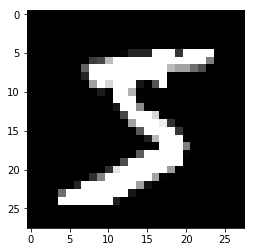

In [8]:
test_img = deprocess(X_train[0])
plt.imshow(test_img, cmap = "gray")

# Create final DataLoader from preprocessed dataset

In [10]:
import torch.utils.data as data_utils
dataset = data_utils.TensorDataset(X_train, y_train)

In [11]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

# Create Helper-Functions
- generate random inputs for the generator 
- to preprocess /deprocess
- create real / fake labels

In [12]:
def generator_input_sampler(batch_size = BATCH_SIZE):
    batch = torch.randn(batch_size, 100)
    clipped_batch = torch.FloatTensor(np.clip(batch.numpy(), -1, 1))
    return clipped_batch

In [13]:
def preprocess_img(img):
    """
    Preprocess the images that the are normalized and clipped to a range between -1 and 1
    Input: Batch of images
    Output: Batch of normalized and clipped images
    """
    img = (img.float() / 255- 0.5) * 2
    img = torch.FloatTensor(np.clip(img.numpy(), -1, 1))      
    return img

def deprocess(x):
    """
    
    """
    x = (x.detach() / 2 + 1) * 255
    x = torch.clamp(x, min = 0, max = 255)
    return x.view(28,28)

def make_labels(size):
    # returns real and fake lables
    return torch.ones(size,1), torch.zeros(size,1)

# Creating Generator and Discriminator

In [14]:
class Generator(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Generator, self).__init__()
        # test leakyReLu(alpha = 0.1) and tanh
        self.network = nn.Sequential(nn.Linear(input_shape, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, output_shape),
                                    nn.Tanh())
    def forward(self, x):
        return self.network(x)

    
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        self.network = nn.Sequential(nn.Linear(input_shape, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        return self.network(x)

In [15]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(device)
input_shape = 100
img_digits_shape = 784 
generator = Generator(input_shape, img_digits_shape).to(device)

discriminator = Discriminator(img_digits_shape).to(device)
    
optimizer_G = optim.Adam(generator.parameters(), lr = 1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr = 1e-3)


cuda


In [16]:
print(generator)
print("\n", discriminator)


Generator(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)

 Discriminator(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


# Training Discriminator and Generator 

In [17]:
import time

/home/sebastian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: This function is deprecated. Please call randint(0, 31 + 1) instead


Episode: 0 -- Discriminator loss: 0.017961356788873672 -- Generator loss: 0.9325588345527649
Episode: 1 -- Discriminator loss: 0.01706552505493164 -- Generator loss: 0.9636668562889099
Episode: 2 -- Discriminator loss: 0.014037024229764938 -- Generator loss: 0.9675827026367188
Episode: 3 -- Discriminator loss: 0.011205964721739292 -- Generator loss: 0.9707319140434265
Episode: 4 -- Discriminator loss: 0.020024748519062996 -- Generator loss: 0.9625110626220703
Episode: 5 -- Discriminator loss: 0.013213865458965302 -- Generator loss: 0.9691997170448303
Episode: 6 -- Discriminator loss: 0.017827555537223816 -- Generator loss: 0.9604365825653076
Episode: 7 -- Discriminator loss: 0.02056632563471794 -- Generator loss: 0.9590949416160583
Episode: 8 -- Discriminator loss: 0.022178998216986656 -- Generator loss: 0.9543471932411194
Episode: 9 -- Discriminator loss: 0.026454325765371323 -- Generator loss: 0.9524633884429932
Episode: 10 -- Discriminator loss: 0.02977798692882061 -- Generator loss

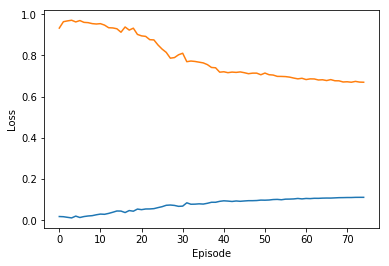

In [20]:
start_time = time.time()
#writer = SummaryWriter()
loss_d = nn.MSELoss()
step = 0
epochs = 75
overall_loss_d = []
overall_loss_g = []
saved_generator_imgs = [] #saves one image each episode
generator_predictions = [] # saves the predictions of the discriminator to the fake images
for epoch in range(epochs):
    episodic_loss_d = []
    episodic_loss_g = []
    for idx, batch in enumerate(data_loader):
        
        # Training the Discriminator:
        discriminator.train()
        generator.eval()
        x, y = batch
        x = x.view(-1,784) # flattens imgs
        x_fake_digits = generator_input_sampler() # create fake digits
        x_fake = generator(x_fake_digits.to(device)) # create fake imgs
        y_true, y_fake = make_labels(BATCH_SIZE) 
        # combine real and fake imgs and combine labels
        x_input = torch.cat((x, x_fake.cpu()), 0).to(device)
        labels = torch.cat((y_true, y_fake), 0).to(device)
        pred = discriminator(x_input).to(device)
        discriminator.zero_grad()
        lossd = loss_d(pred, labels).mean()
        #writer.add_scalar("Discriminator loss",lossd.mean(), step)
        lossd.backward()
        optimizer_D.step()
        episodic_loss_d.append(lossd.cpu().detach().numpy().mean())
        
        # Training the Generator:
        discriminator.eval()
        generator.train()
        x_fake_digits = generator_input_sampler() # create fake digits
        x_fake_imgs = generator(x_fake_digits.to(device)) # create fake imgs
        pred = discriminator(x_fake_imgs).to(device) 
        if idx == 0:
            # Saves the first produced image each episode
            random_nr = np.random.random_integers(0,BATCH_SIZE-1)
            saved_generator_imgs.append(deprocess(x_fake_imgs[random_nr].cpu()))
            generator_predictions.append(pred[random_nr].cpu())
        generator.zero_grad()
        lossg = loss_d(pred, torch.ones(64).to(device)).mean()
        #writer.add_scalar("Generator loss",lossg.mean(), step)
        lossg.backward()
        optimizer_G.step()
        episodic_loss_g.append(lossg.cpu().detach().numpy().mean())       
        step += 1
        # Debugging
        #if idx == 1:
        #    break
    overall_loss_g.append(np.array(episodic_loss_g).mean())
    overall_loss_d.append(np.array(episodic_loss_d).mean())
    print("Episode: {} -- Discriminator loss: {} -- Generator loss: {}".format(epoch, np.array(episodic_loss_d).mean(), np.array(episodic_loss_g).mean()))

end_time = time.time()

print("Training for {} min".format((end_time-start_time)/60))
plt.plot(overall_loss_d)
plt.plot(overall_loss_g)
plt.ylabel("Loss")
plt.xlabel("Episode")
plt.show()

# Plot Created images by the Generator in each training epoch

0 == Fake and 1 == Real
First Episode unsure since untrained on Real Data


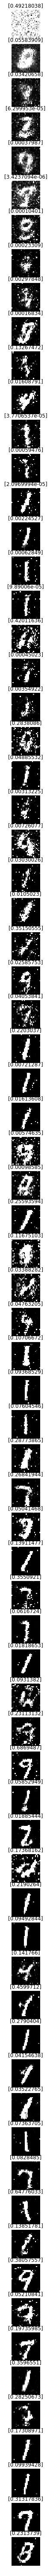

In [21]:
fig, axes = plt.subplots(len(saved_generator_imgs),1, figsize=(6, 110))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()

print("0 == Fake and 1 == Real")
print("First Episode unsure since untrained on Real Data")

for idx in range(len(saved_generator_imgs)):
    axes[idx].axis('off')
    axes[idx].imshow(saved_generator_imgs[idx], cmap = "gray")
    axes[idx].set_title(generator_predictions[idx].detach().numpy())

# Additional Testing

## Compare Activation Functions

C:\Users\DESEDIT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


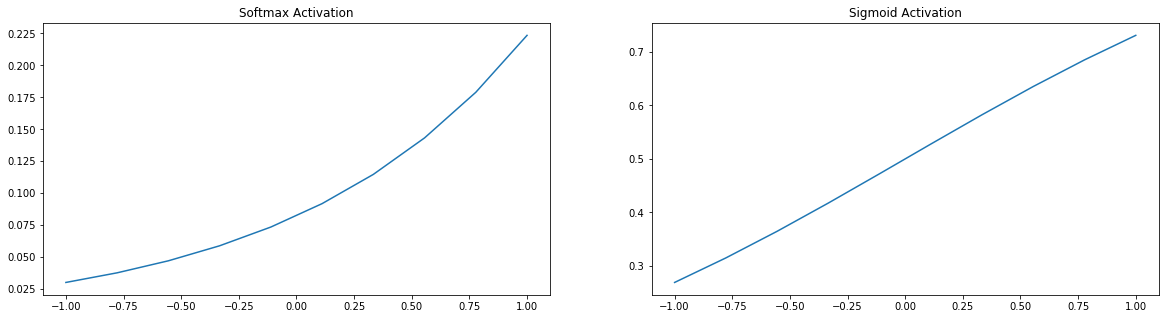

In [161]:
x_vals = np.linspace(-1,1,10)
y_vals_soft = F.softmax(torch.Tensor(x_vals))
y_vals_sig = F.sigmoid(torch.Tensor(x_vals))
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Softmax Activation")
plt.plot(x_vals, y_vals_soft.numpy())

plt.subplot(1,2,2)
plt.title("Sigmoid Activation")
plt.plot(x_vals, y_vals_sig.numpy())
plt.show()

In [243]:
np.random.random_integers(0,len(X_train))

C:\Users\DESEDIT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  """Entry point for launching an IPython kernel.


18949